In [4]:
# CÉLULA 1: Imports y Carga de Datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from scipy import sparse
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score
import time

# Imports de modelos
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import tensorflow as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

print("🚀 Iniciando fase de entrenamiento...")

def load_processed_data(path='processed_data'):
    """Carga datos sparse y arrays numpy"""
    try:
        print(f"📂 Cargando datos desde '{path}'...")
        
        # Cargar matrices sparse
        X_train = sparse.load_npz(f'{path}/X_train_tfidf.npz')
        X_val = sparse.load_npz(f'{path}/X_val_tfidf.npz')
        X_test = sparse.load_npz(f'{path}/X_test_tfidf.npz')
        
        # Cargar etiquetas
        y_train = np.load(f'{path}/y_train.npy')
        y_val = np.load(f'{path}/y_val.npy')
        y_test = np.load(f'{path}/y_test.npy')
        
        print(f"✅ Datos cargados exitosamente.")
        print(f"   X_train shape: {X_train.shape} (Sparse)")
        print(f"   y_train shape: {y_train.shape}")
        return X_train, X_val, X_test, y_train, y_val, y_test
        
    except FileNotFoundError:
        print("❌ Error: No se encuentran los archivos. Asegúrate de haber ejecutado la fase de exportación.")
        return None

# Ejecutar carga
X_train, X_val, X_test, y_train, y_val, y_test = load_processed_data()

🚀 Iniciando fase de entrenamiento...
📂 Cargando datos desde 'processed_data'...
✅ Datos cargados exitosamente.
   X_train shape: (162451, 5000) (Sparse)
   y_train shape: (162451,)


# Modelos Clásicos (Naive Bayes y Regresión Logística)
Algo importante a considerar son los falsos negativos, es decir que se diagnostica como "no suicidio", cuando en realidad es suicidio, para proceder con un análisis y apoyo correcto del sujeto, y los falsos positivos, no habría mayor riesgo mas que perder dinero en apoyo innecesario, o un análisis más profundo.

En logistic regression, utilizando GridSearch, se buscaron los parámetros para F1, para encontrar un mejor balance entre precisión y recall, para no tener falsos negativos pero 
tampoco saturar a los psicólogos con falsos positivos.


🤖 1. Entrenando Naive Bayes...
✅ Naive Bayes - Acc: 0.8958 | F1: 0.9010 | Recall: 0.9478
   📉 Generando gráfica de Costo para: Curva de Aprendizaje - Naive Bayes...


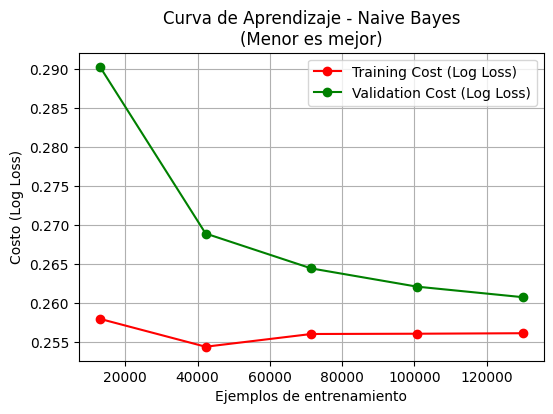


📑 Matriz de Confusión (Naive Bayes):


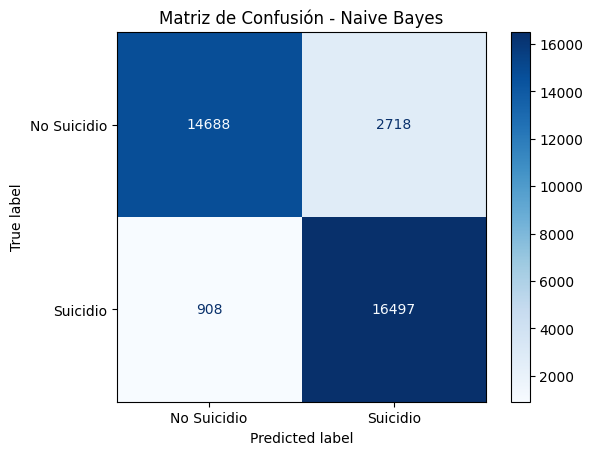


🤖 2. Optimizando Logistic Regression (GridSearch)...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
✅ Búsqueda terminada en 16.58s
   🏆 Mejores parámetros: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
   📊 Accuracy: 0.9328
   📊 F1-Score: 0.9323
   ⚠️ Recall (Suicidio): 0.9254 (¡Crítico para este proyecto!)

📉 Generando Curva de Aprendizaje para Logistic Regression (COSTO)...
   📉 Generando gráfica de Costo para: Curva de Aprendizaje - Logistic Regression...


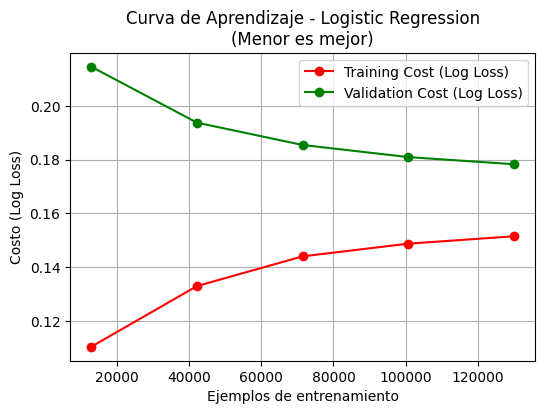


📑 Matriz de Confusión (Logistic Regression):


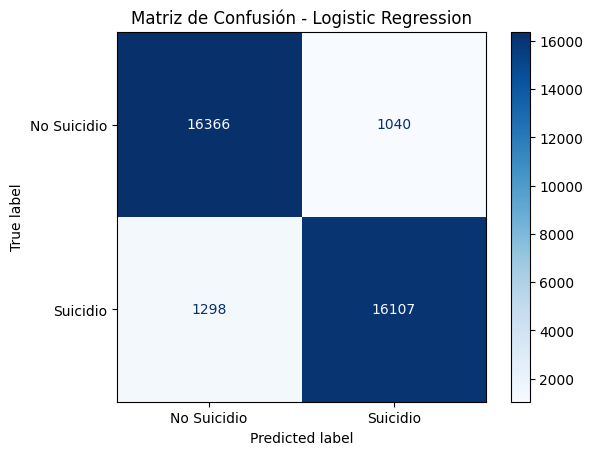


📈 Generando Comparación ROC Curves...


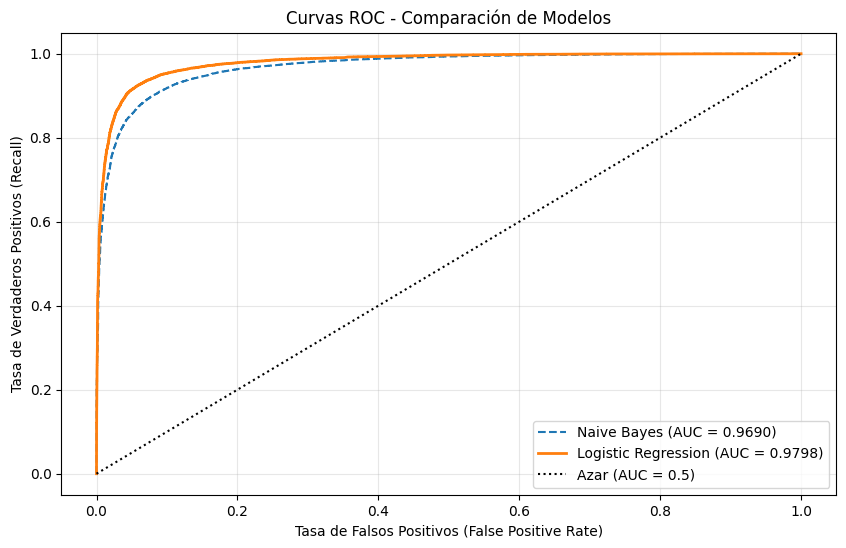

In [13]:
# CÉLULA 2 MEJORADA: Modelos Clásicos + Learning Curves (COSTO) + ROC Curves + Matrices de Confusión
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, recall_score, accuracy_score, f1_score, roc_curve, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
import time

results = {}

def plot_learning_curve(estimator, title, X, y, cv=5):
    """Genera curva de aprendizaje basada en Función de Costo (Log Loss)"""
    print(f"   📉 Generando gráfica de Costo para: {title}...")
    
    # Usamos 'neg_log_loss'. Scikit-learn usa valores negativos porque optimiza maximizando.
    # El costo real es el valor positivo de esto.
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 5), scoring='neg_log_loss'
    )
    
    # Invertimos el signo (-) para graficar el Costo positivo (Log Loss)
    # Menor valor = Mejor modelo
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.figure(figsize=(6, 4))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Cost (Log Loss)")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation Cost (Log Loss)")
    
    plt.title(f"{title}\n(Menor es mejor)")
    plt.xlabel("Ejemplos de entrenamiento")
    plt.ylabel("Costo (Log Loss)")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# ---------------------------------------------------------
# 1. NAIVE BAYES (Simple, sin mucho tuning)
# ---------------------------------------------------------
print("\n🤖 1. Entrenando Naive Bayes...")
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_val)

acc_nb = accuracy_score(y_val, y_pred_nb)
f1_nb = f1_score(y_val, y_pred_nb)
recall_nb = recall_score(y_val, y_pred_nb)

print(f"✅ Naive Bayes - Acc: {acc_nb:.4f} | F1: {f1_nb:.4f} | Recall: {recall_nb:.4f}")
results['Naive Bayes'] = {'model': nb_model, 'accuracy': acc_nb, 'f1_score': f1_nb, 'recall': recall_nb}

# Gráfica Learning Curve para Naive Bayes (COSTO)
plot_learning_curve(nb_model, "Curva de Aprendizaje - Naive Bayes", X_train, y_train)

# --- NUEVO: Matriz de Confusión para Naive Bayes ---
print("\n📑 Matriz de Confusión (Naive Bayes):")
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_nb, display_labels=['No Suicidio', 'Suicidio'], cmap='Blues')
plt.title("Matriz de Confusión - Naive Bayes")
plt.show()

# ---------------------------------------------------------
# 2. LOGISTIC REGRESSION CON GRID SEARCH (Optimización Profesional)
# ---------------------------------------------------------
print("\n🤖 2. Optimizando Logistic Regression (GridSearch)...")
start_time = time.time()

# Definimos una rejilla de valores para probar
param_grid = {
    'C': [0.1, 1, 10],            # Fuerza de regularización
    'solver': ['liblinear'],      # Buen solver para datasets medianos
    'penalty': ['l2']             # Tipo de penalización estándar
}

# Mantenemos scoring='f1' para la selección del mejor modelo (GridSearch)
grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), 
                    param_grid, 
                    cv=3,             # Validación cruzada de 3 pliegues
                    scoring='f1',     # Optimizamos para F1
                    n_jobs=-1,        # Usar todos los procesadores
                    verbose=1)

grid.fit(X_train, y_train)
best_lr = grid.best_estimator_

train_time = time.time() - start_time
print(f"✅ Búsqueda terminada en {train_time:.2f}s")
print(f"   🏆 Mejores parámetros: {grid.best_params_}")

# Predicción con el modelo GANADOR
y_pred_lr = best_lr.predict(X_val)
acc_lr = accuracy_score(y_val, y_pred_lr)
f1_lr = f1_score(y_val, y_pred_lr)
recall_lr = recall_score(y_val, y_pred_lr)

print(f"   📊 Accuracy: {acc_lr:.4f}")
print(f"   📊 F1-Score: {f1_lr:.4f}")
print(f"   ⚠️ Recall (Suicidio): {recall_lr:.4f} (¡Crítico para este proyecto!)")

results['Logistic Regression'] = {'model': best_lr, 'accuracy': acc_lr, 'f1_score': f1_lr}

# ---------------------------------------------------------
# 3. VISUALIZACIÓN DE ERRORES (Logistic Regression)
# ---------------------------------------------------------
print("\n📉 Generando Curva de Aprendizaje para Logistic Regression (COSTO)...")
plot_learning_curve(best_lr, "Curva de Aprendizaje - Logistic Regression", X_train, y_train)

print("\n📑 Matriz de Confusión (Logistic Regression):")
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_lr, display_labels=['No Suicidio', 'Suicidio'], cmap='Blues')
plt.title("Matriz de Confusión - Logistic Regression")
plt.show()

# ---------------------------------------------------------
# 4. CURVAS ROC - AUC (COMPARACIÓN FINAL)
# ---------------------------------------------------------
print("\n📈 Generando Comparación ROC Curves...")

# Obtener probabilidades (necesarias para ROC) de la clase positiva (índice 1)
y_prob_nb = nb_model.predict_proba(X_val)[:, 1]
y_prob_lr = best_lr.predict_proba(X_val)[:, 1]

# Calcular AUC
auc_nb = roc_auc_score(y_val, y_prob_nb)
auc_lr = roc_auc_score(y_val, y_prob_lr)

# Calcular puntos de la curva
fpr_nb, tpr_nb, _ = roc_curve(y_val, y_prob_nb)
fpr_lr, tpr_lr, _ = roc_curve(y_val, y_prob_lr)

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(fpr_nb, tpr_nb, linestyle='--', label=f'Naive Bayes (AUC = {auc_nb:.4f})')
plt.plot(fpr_lr, tpr_lr, linewidth=2, label=f'Logistic Regression (AUC = {auc_lr:.4f})')
plt.plot([0, 1], [0, 1], 'k:', label='Azar (AUC = 0.5)') # Línea diagonal

plt.title('Curvas ROC - Comparación de Modelos')
plt.xlabel('Tasa de Falsos Positivos (False Positive Rate)')
plt.ylabel('Tasa de Verdaderos Positivos (Recall)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()



# Conclusión
Podemos concluir que los dos modelos tuvieron un accuracy muy bueno, arriba de 89, pero para la aplicación, podemos observar que naive bayes, maneja mejor los falsos negativosm teniendo un Recall de 0.9478 pero es un "trade off", porque su número de falsos positivos es mayor.
En cambio logística regresión, tiene un mayor balance entre falsos positivos y negativos, con un recall de 0.9254, pero con mejor F1 y accuracy.

# Red Neuronal (Deep Learning)


🧠 Configurando Red Neuronal...
✅ Conversión a denso exitosa.


/Users/hectorcabrald/Documents/Mis documentos/1 TRABAJOS HECTOR/Universidad/9vo semestre/Curso posgrado Inteligencia artificial/Proyecto_final/suicide_depression_detection/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │       320,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 322,177 (1.23 MB)

 Trainable params: 322,177 (1.23 MB)

 Non-trainable params: 0 (0.00 B)


🔥 Entrenando Red Neuronal...
Epoch 1/20
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 67s 13ms/step - accuracy: 0.9265 - loss: 0.1967 - val_accuracy: 0.9342 - val_loss: 0.1756
Epoch 2/20
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 52s 10ms/step - accuracy: 0.9400 - loss: 0.1605 - val_accuracy: 0.9346 - val_loss: 0.1739
Epoch 3/20
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 88s 12ms/step - accuracy: 0.9481 - loss: 0.1415 - val_accuracy: 0.9347 - val_loss: 0.1742
Epoch 4/20
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 54s 11ms/step - accuracy: 0.9572 - loss: 0.1219 - val_accuracy: 0.9341 - val_loss: 0.1826
Epoch 5/20
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 49s 10ms/step - accuracy: 0.9638 - loss: 0.1045 - val_accuracy: 0.9339 - val_loss: 0.1949

📊 Evaluando modelo...
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

✅ Neural Network completada en 353.97s
   🎯 Accuracy (Val): 0.9346
   🎯 F1-Score (Val): 0.9341
   ⚠️ Recall (Val):   0.9261


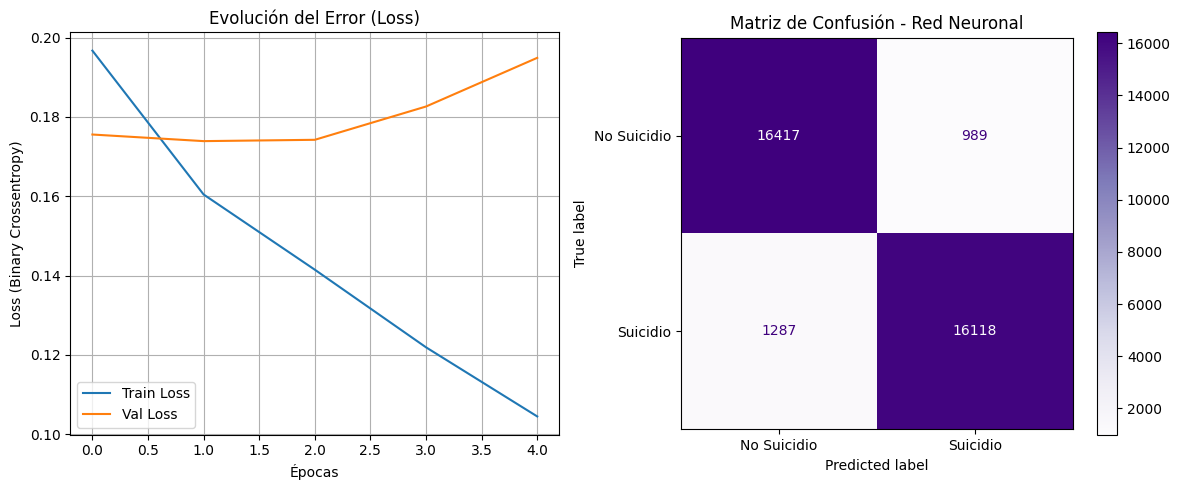

In [ ]:
# CÉLULA 3: Red Neuronal (MLP) RELU con Métricas Completas
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, f1_score, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import time

print("\n🧠 Configurando Red Neuronal...")

# Las redes neuronales en Keras prefieren matrices densas
# Si tienes mucha RAM (>16GB), puedes convertir todo. Si no, usa batches.
# Para 5000 features, convertir a denso suele ser seguro en Colab.
try:
    X_train_dense = X_train.toarray()
    X_val_dense = X_val.toarray()
    print("✅ Conversión a denso exitosa.")
except Exception as e:
    print(f"⚠️ Error convirtiendo a denso (falta RAM?): {e}")

def build_neural_network(input_dim):
    model = Sequential([
        # Capa de entrada (5000 neuronas -> 64 neuronas)
        Dense(64, input_dim=input_dim, activation='relu'),
        Dropout(0.3), # Regularización para evitar Overfitting
        
        # Capa oculta
        Dense(32, activation='relu'),
        Dropout(0.2),
        
        # Capa de salida (1 neurona, sigmoide para binario 0/1)
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model_nn = build_neural_network(X_train.shape[1])
model_nn.summary()

# Callbacks para detener si no mejora (Evita Overfitting)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("\n🔥 Entrenando Red Neuronal...")
start_time = time.time()

history = model_nn.fit(
    X_train_dense, y_train,
    epochs=20,           # Máximo de épocas (parará antes por early_stopping)
    batch_size=32,       # Ajustar según memoria
    validation_data=(X_val_dense, y_val),
    callbacks=[early_stopping],
    verbose=1
)

train_time = time.time() - start_time

# ---------------------------------------------------------
# EVALUACIÓN Y MÉTRICAS
# ---------------------------------------------------------
print("\n📊 Evaluando modelo...")
# Predicción (probabilidades)
y_pred_prob = model_nn.predict(X_val_dense)
# Convertir probabilidad a clase (Umbral 0.5)
y_pred_nn = (y_pred_prob > 0.5).astype(int).flatten()

# Cálculo de métricas
acc_nn = accuracy_score(y_val, y_pred_nn)
f1_nn = f1_score(y_val, y_pred_nn)
recall_nn = recall_score(y_val, y_pred_nn)

# Guardar en diccionario de resultados
results['Neural Network'] = {
    'model': model_nn,
    'accuracy': acc_nn,
    'f1_score': f1_nn,
    'recall': recall_nn,
    'time': train_time,
    'history': history
}

print(f"\n✅ Neural Network completada en {train_time:.2f}s")
print(f"   🎯 Accuracy (Val): {acc_nn:.4f}")
print(f"   🎯 F1-Score (Val): {f1_nn:.4f}")
print(f"   ⚠️ Recall (Val):   {recall_nn:.4f}")

# ---------------------------------------------------------
# VISUALIZACIÓN
# ---------------------------------------------------------
plt.figure(figsize=(12, 5))

# 1. Gráfica de Pérdida (Loss) durante el entrenamiento
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Evolución del Error (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Loss (Binary Crossentropy)')
plt.legend()
plt.grid(True)

# 2. Matriz de Confusión
plt.subplot(1, 2, 2)
# Usamos el array de la matriz para graficarlo manualmente o con display
cm = confusion_matrix(y_val, y_pred_nn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Suicidio', 'Suicidio'])
disp.plot(cmap='Purples', ax=plt.gca()) # Usamos morado para distinguir de los otros
plt.title('Matriz de Confusión - Red Neuronal')

plt.tight_layout()
plt.show()


🧠 Configurando Red Neuronal...
✅ Conversión a denso exitosa.


/Users/hectorcabrald/Documents/Mis documentos/1 TRABAJOS HECTOR/Universidad/9vo semestre/Curso posgrado Inteligencia artificial/Proyecto_final/suicide_depression_detection/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │       320,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 322,177 (1.23 MB)

 Trainable params: 322,177 (1.23 MB)

 Non-trainable params: 0 (0.00 B)


🔥 Entrenando Red Neuronal...
Epoch 1/20
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 61s 11ms/step - accuracy: 0.9275 - loss: 0.1967 - val_accuracy: 0.9324 - val_loss: 0.1775
Epoch 2/20
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 75s 15ms/step - accuracy: 0.9365 - loss: 0.1667 - val_accuracy: 0.9328 - val_loss: 0.1757
Epoch 3/20
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 68s 13ms/step - accuracy: 0.9386 - loss: 0.1589 - val_accuracy: 0.9334 - val_loss: 0.1764
Epoch 4/20
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 49s 10ms/step - accuracy: 0.9403 - loss: 0.1543 - val_accuracy: 0.9340 - val_loss: 0.1777
Epoch 5/20
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 55s 11ms/step - accuracy: 0.9422 - loss: 0.1503 - val_accuracy: 0.9334 - val_loss: 0.1797

📊 Evaluando modelo...
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

✅ Neural Network completada en 333.13s
   🎯 Accuracy (Val): 0.9328
   🎯 F1-Score (Val): 0.9328
   ⚠️ Recall (Val):   0.9325


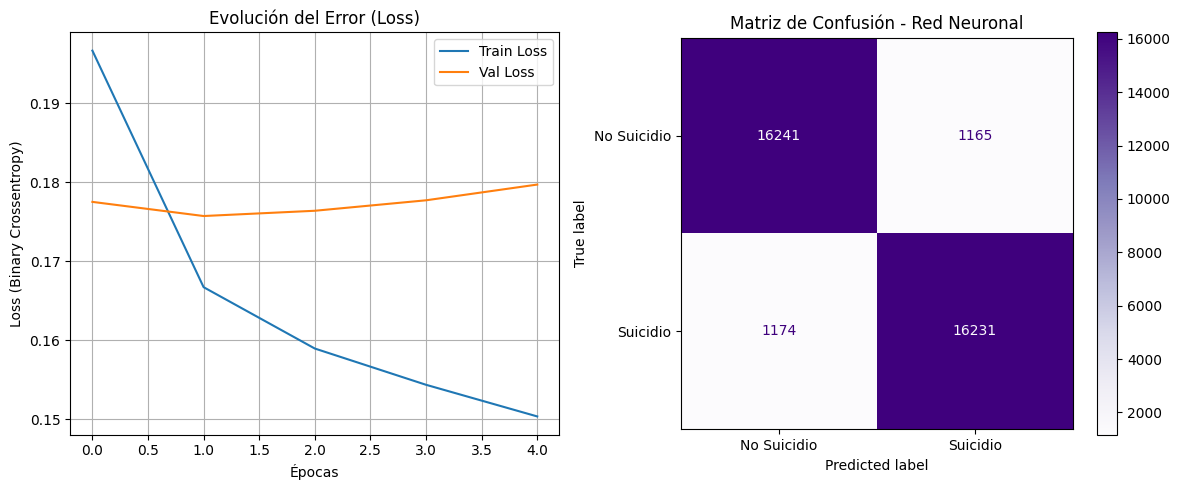

In [ ]:
# CÉLULA 3: Red Neuronal (MLP) GELU con Métricas Completas
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, f1_score, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import time

print("\n🧠 Configurando Red Neuronal...")

# Las redes neuronales en Keras prefieren matrices densas
# Si tienes mucha RAM (>16GB), puedes convertir todo. Si no, usa batches.
# Para 5000 features, convertir a denso suele ser seguro en Colab.
try:
    X_train_dense = X_train.toarray()
    X_val_dense = X_val.toarray()
    print("✅ Conversión a denso exitosa.")
except Exception as e:
    print(f"⚠️ Error convirtiendo a denso (falta RAM?): {e}")

def build_neural_network(input_dim):
    model = Sequential([
        # Capa de entrada (5000 neuronas -> 64 neuronas)
        Dense(64, input_dim=input_dim, activation='gelu'),
        Dropout(0.3), # Regularización para evitar Overfitting
        
        # Capa oculta
        Dense(32, activation='relu'),
        Dropout(0.2),
        
        # Capa de salida (1 neurona, sigmoide para binario 0/1)
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model_nn = build_neural_network(X_train.shape[1])
model_nn.summary()

# Callbacks para detener si no mejora (Evita Overfitting)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("\n🔥 Entrenando Red Neuronal...")
start_time = time.time()

history = model_nn.fit(
    X_train_dense, y_train,
    epochs=20,           # Máximo de épocas (parará antes por early_stopping)
    batch_size=32,       # Ajustar según memoria
    validation_data=(X_val_dense, y_val),
    callbacks=[early_stopping],
    verbose=1
)

train_time = time.time() - start_time

# ---------------------------------------------------------
# EVALUACIÓN Y MÉTRICAS
# ---------------------------------------------------------
print("\n📊 Evaluando modelo...")
# Predicción (probabilidades)
y_pred_prob = model_nn.predict(X_val_dense)
# Convertir probabilidad a clase (Umbral 0.5)
y_pred_nn = (y_pred_prob > 0.5).astype(int).flatten()

# Cálculo de métricas
acc_nn = accuracy_score(y_val, y_pred_nn)
f1_nn = f1_score(y_val, y_pred_nn)
recall_nn = recall_score(y_val, y_pred_nn)

# Guardar en diccionario de resultados
results['Neural Network'] = {
    'model': model_nn,
    'accuracy': acc_nn,
    'f1_score': f1_nn,
    'recall': recall_nn,
    'time': train_time,
    'history': history
}

print(f"\n✅ Neural Network completada en {train_time:.2f}s")
print(f"   🎯 Accuracy (Val): {acc_nn:.4f}")
print(f"   🎯 F1-Score (Val): {f1_nn:.4f}")
print(f"   ⚠️ Recall (Val):   {recall_nn:.4f}")

# ---------------------------------------------------------
# VISUALIZACIÓN
# ---------------------------------------------------------
plt.figure(figsize=(12, 5))

# 1. Gráfica de Pérdida (Loss) durante el entrenamiento
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Evolución del Error (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Loss (Binary Crossentropy)')
plt.legend()
plt.grid(True)

# 2. Matriz de Confusión
plt.subplot(1, 2, 2)
# Usamos el array de la matriz para graficarlo manualmente o con display
cm = confusion_matrix(y_val, y_pred_nn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Suicidio', 'Suicidio'])
disp.plot(cmap='Purples', ax=plt.gca()) # Usamos morado para distinguir de los otros
plt.title('Matriz de Confusión - Red Neuronal')

plt.tight_layout()
plt.show()


🧠 Configurando Red Neuronal...
✅ Conversión a denso exitosa.


/Users/hectorcabrald/Documents/Mis documentos/1 TRABAJOS HECTOR/Universidad/9vo semestre/Curso posgrado Inteligencia artificial/Proyecto_final/suicide_depression_detection/venv/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 64)             │       320,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 322,177 (1.23 MB)

 Trainable params: 322,177 (1.23 MB)

 Non-trainable params: 0 (0.00 B)


🔥 Entrenando Red Neuronal...
Epoch 1/20
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 63s 12ms/step - accuracy: 0.9253 - loss: 0.1977 - val_accuracy: 0.9332 - val_loss: 0.1765
Epoch 2/20
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 80s 11ms/step - accuracy: 0.9398 - loss: 0.1604 - val_accuracy: 0.9348 - val_loss: 0.1737
Epoch 3/20
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 60s 12ms/step - accuracy: 0.9478 - loss: 0.1413 - val_accuracy: 0.9347 - val_loss: 0.1761
Epoch 4/20
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 55s 11ms/step - accuracy: 0.9565 - loss: 0.1230 - val_accuracy: 0.9344 - val_loss: 0.1869
Epoch 5/20
5077/5077 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - accuracy: 0.9633 - loss: 0.1070 - val_accuracy: 0.9346 - val_loss: 0.1918

📊 Evaluando modelo...
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

✅ Neural Network completada en 363.65s
   🎯 Accuracy (Val): 0.9348
   🎯 F1-Score (Val): 0.9346
   ⚠️ Recall (Val):   0.9310


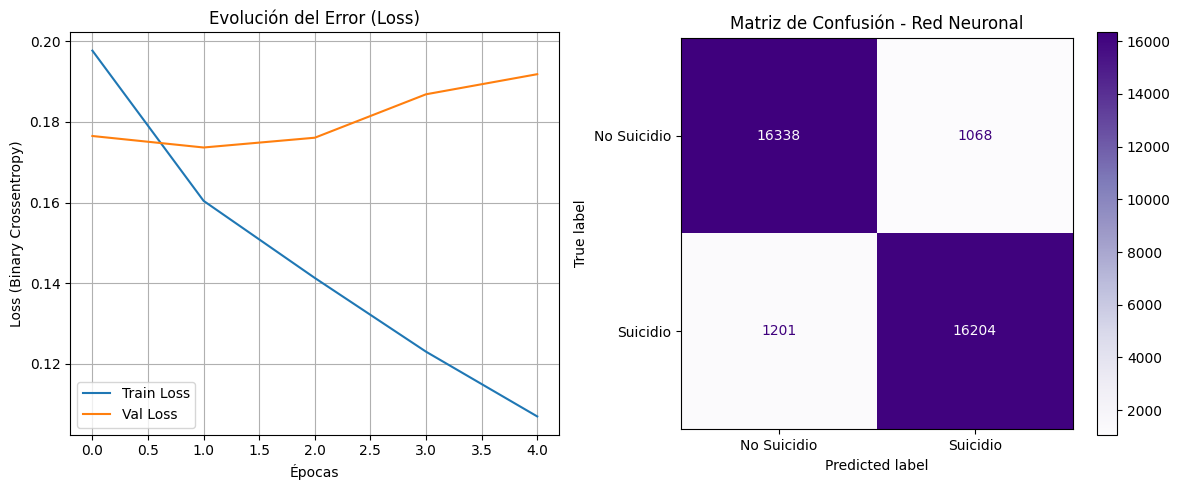

In [ ]:
# CÉLULA 3: Red Neuronal (MLP) LeakyReLU con Métricas Completas
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, f1_score, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import time

print("\n🧠 Configurando Red Neuronal...")

# Las redes neuronales en Keras prefieren matrices densas
# Si tienes mucha RAM (>16GB), puedes convertir todo. Si no, usa batches.
# Para 5000 features, convertir a denso suele ser seguro en Colab.
try:
    X_train_dense = X_train.toarray()
    X_val_dense = X_val.toarray()
    print("✅ Conversión a denso exitosa.")
except Exception as e:
    print(f"⚠️ Error convirtiendo a denso (falta RAM?): {e}")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU

def build_neural_network(input_dim):
    model = Sequential([
        # Capa de entrada (5000 -> 64)
        Dense(64, input_dim=input_dim),
        LeakyReLU(alpha=0.01),   # Activación correcta
        Dropout(0.3),            # Evita overfitting
        
        # Capa oculta
        Dense(32),
        LeakyReLU(alpha=0.01),   # Puedes usar ReLU, pero LeakyReLU suele ser mejor
        Dropout(0.2),
        
        # Capa de salida
        Dense(1, activation='sigmoid') # Clasificación binaria
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model


model_nn = build_neural_network(X_train.shape[1])
model_nn.summary()

# Callbacks para detener si no mejora (Evita Overfitting)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("\n🔥 Entrenando Red Neuronal...")
start_time = time.time()

history = model_nn.fit(
    X_train_dense, y_train,
    epochs=20,           # Máximo de épocas (parará antes por early_stopping)
    batch_size=32,       # Ajustar según memoria
    validation_data=(X_val_dense, y_val),
    callbacks=[early_stopping],
    verbose=1
)

train_time = time.time() - start_time

# ---------------------------------------------------------
# EVALUACIÓN Y MÉTRICAS
# ---------------------------------------------------------
print("\n📊 Evaluando modelo...")
# Predicción (probabilidades)
y_pred_prob = model_nn.predict(X_val_dense)
# Convertir probabilidad a clase (Umbral 0.5)
y_pred_nn = (y_pred_prob > 0.5).astype(int).flatten()

# Cálculo de métricas
acc_nn = accuracy_score(y_val, y_pred_nn)
f1_nn = f1_score(y_val, y_pred_nn)
recall_nn = recall_score(y_val, y_pred_nn)

# Guardar en diccionario de resultados
results['Neural Network'] = {
    'model': model_nn,
    'accuracy': acc_nn,
    'f1_score': f1_nn,
    'recall': recall_nn,
    'time': train_time,
    'history': history
}

print(f"\n✅ Neural Network completada en {train_time:.2f}s")
print(f"   🎯 Accuracy (Val): {acc_nn:.4f}")
print(f"   🎯 F1-Score (Val): {f1_nn:.4f}")
print(f"   ⚠️ Recall (Val):   {recall_nn:.4f}")

# ---------------------------------------------------------
# VISUALIZACIÓN
# ---------------------------------------------------------
plt.figure(figsize=(12, 5))

# 1. Gráfica de Pérdida (Loss) durante el entrenamiento
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Evolución del Error (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Loss (Binary Crossentropy)')
plt.legend()
plt.grid(True)

# 2. Matriz de Confusión
plt.subplot(1, 2, 2)
# Usamos el array de la matriz para graficarlo manualmente o con display
cm = confusion_matrix(y_val, y_pred_nn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Suicidio', 'Suicidio'])
disp.plot(cmap='Purples', ax=plt.gca()) # Usamos morado para distinguir de los otros
plt.title('Matriz de Confusión - Red Neuronal')

plt.tight_layout()
plt.show()